In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image, plotting

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [28]:
#Fixing seed for reproducibility
#np.random.seed(0)

In [29]:
#Loading data
from nilearn import datasets
num = 40
adhd_data = datasets.fetch_adhd(n_subjects=num)

In [30]:
adhd_data.keys()

## “func” features the paths to the rs-fMRI data images; 
## “confounds” are the CSV files containing the nuisance variables (confounds) we want to be aware of as not to affect our analysis; 
## “phenotypic” provides explanations for the preprocessing steps; 
## “description” is, well, description of the dataset.

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [31]:
len(adhd_data['func'])

40

In [32]:
#Getting the functional files
func = adhd_data.func
print(func[0])

/Users/larissapassine/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


Decomposition
We use Nilearn's method for group-level ICA (CanICA) which allows for control over single subject variability, especially given that we are interested in functional networks. For this, we:

get the independent components using masker_.inverse_transform;
plot these components;
use NiftiMapsMasker function to "summarize" the brain signals we obtained using ICA;
transform the extracted data to time-series by using the fit_transform method.
get functional connectivity coefficients using the ConnectivityMeasure function after having compared three different measures of fuctional connectivity;
examine resulting connectivity across all subjects

In [33]:
#Using nilearn's individual component analysis for group level
from nilearn import decomposition

canica = decomposition.CanICA(n_components=20, mask_strategy='background')
canica.fit(func)

CanICA(mask_strategy='background')

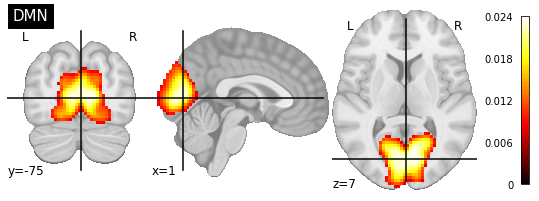

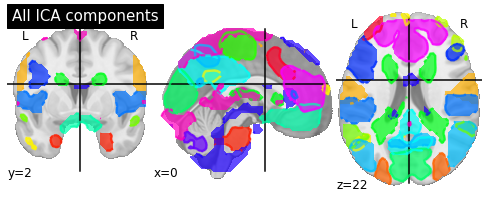

In [34]:
#Retrieving the components
components = canica.components_

#Using a masker to project into the 3D space
components_img = canica.masker_.inverse_transform(components)

#Plotting the default mode network (DMN) without region extraction
plotting.plot_stat_map(image.index_img(components_img, 9), title='DMN')
plotting.show()

#Plotting all the components
plotting.plot_prob_atlas(components_img, title='All ICA components')
plotting.show()

In [35]:
#Using a filter to extract the regions time series 
from nilearn import input_data
masker = input_data.NiftiMapsMasker(components_img, smoothing_fwhm=6,
                         standardize=False, detrend=True,
                         t_r=2.5, low_pass=0.1,
                         high_pass=0.01)



#Computing the regions signals and extracting the phenotypic information of interest
subjects = []
adhds = []
sites = []
labels = []
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd == 1:
        adhds.append(time_series)    
    sites.append(phenotypic['site'])
    labels.append(phenotypic['adhd'])

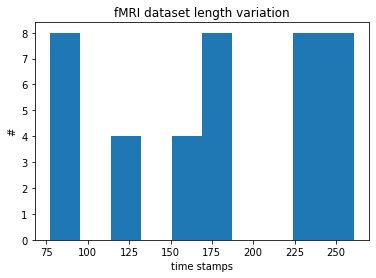

In [36]:
plt.hist([len(i) for i in subjects])
plt.title('fMRI dataset length variation')
plt.xlabel('time stamps')
plt.ylabel('#')
plt.show()

In [37]:
#Comparing the three types of functional connectivity between the regions of interest
from nilearn.connectome import ConnectivityMeasure

connectivity_biomarkers = {}

kinds = ['correlation', 'partial correlation', 'tangent']
for kind in kinds:
    conn_measure = ConnectivityMeasure(kind=kind, vectorize=True)
    connectivity_biomarkers[kind] = conn_measure.fit_transform(subjects)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers['correlation'].shape[1]))

210 correlation biomarkers for each subject.


In [38]:
#Stratifying the data to use for comparison

from sklearn.model_selection import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(sites, labels)]
cv = StratifiedKFold(n_splits=3)

In [39]:
#Classifying using the connectivity coefficients and linear support vector
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

mean_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc,
                                connectivity_biomarkers[kind],
                                y=labels,
                                cv=cv,
                                groups=labels,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())

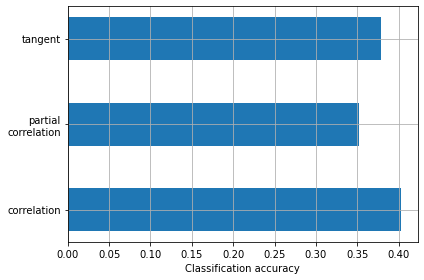

In [40]:
#Visualizing results and accuracy
from nilearn.plotting import show

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [kind.replace(' ', '\n') for kind in kinds]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()

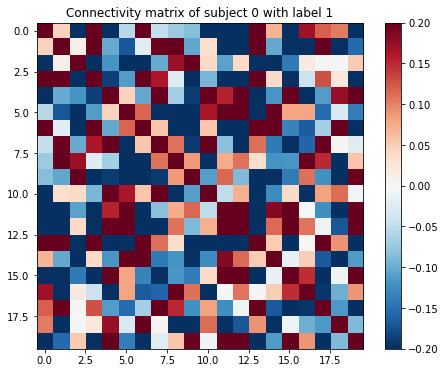

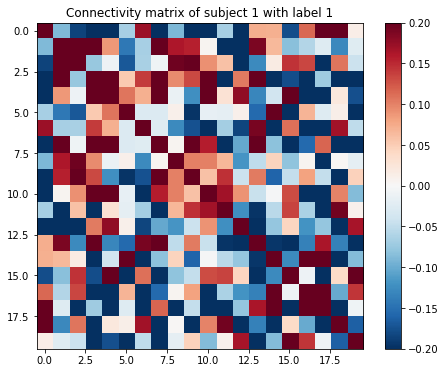

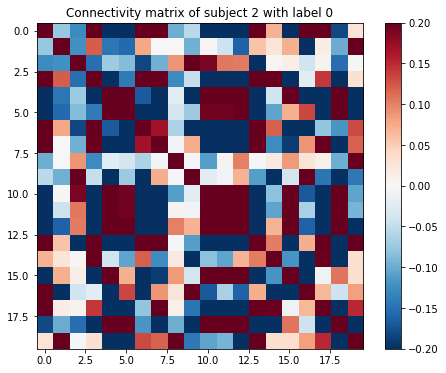

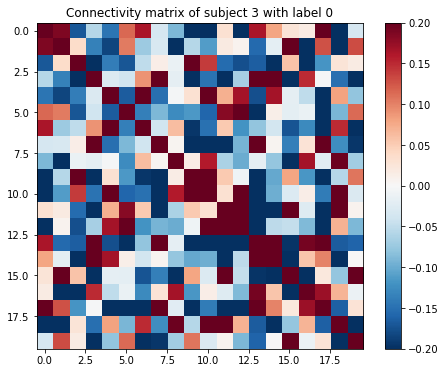

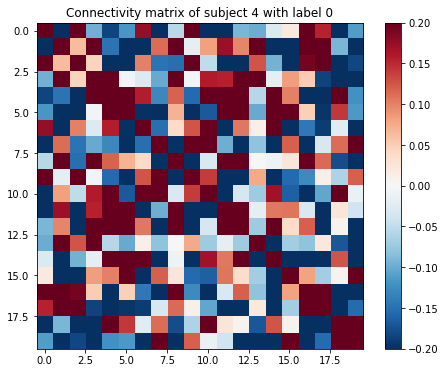

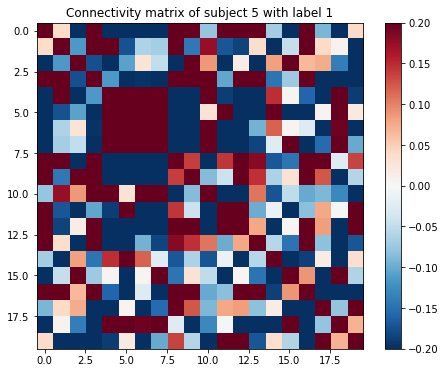

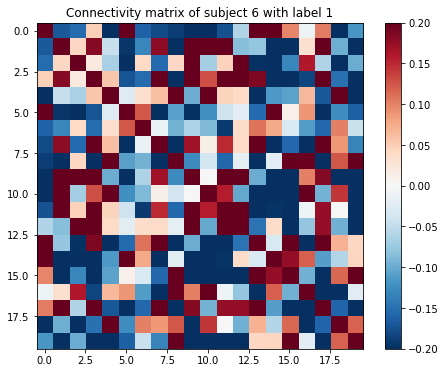

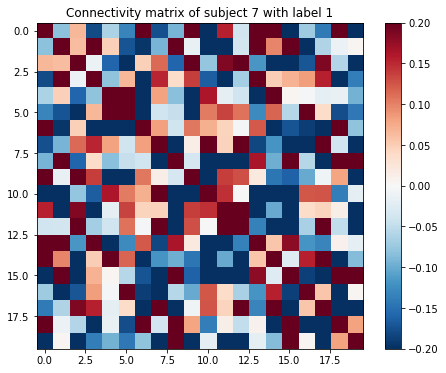

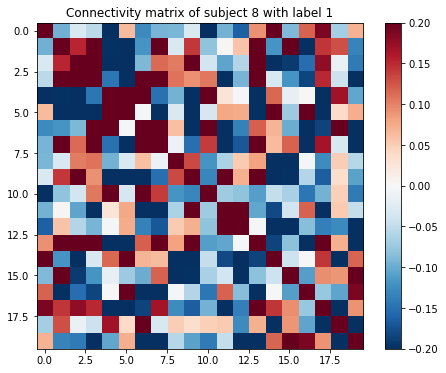

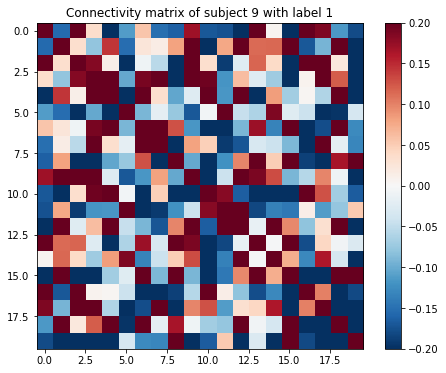

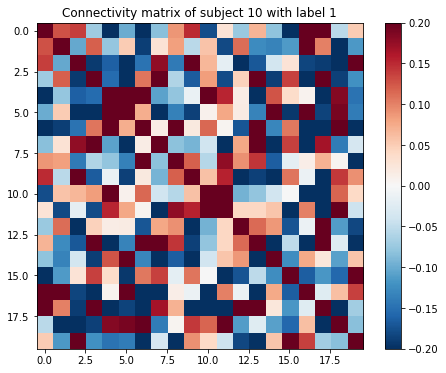

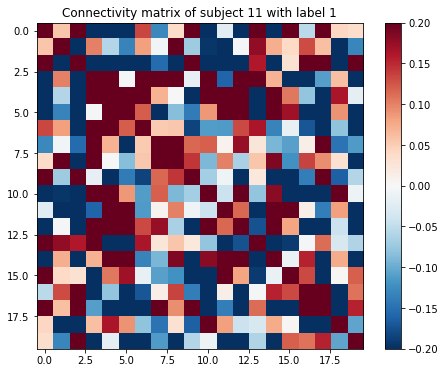

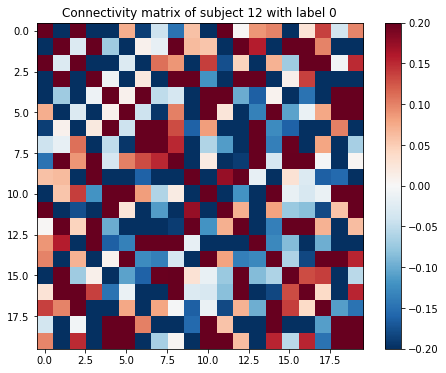

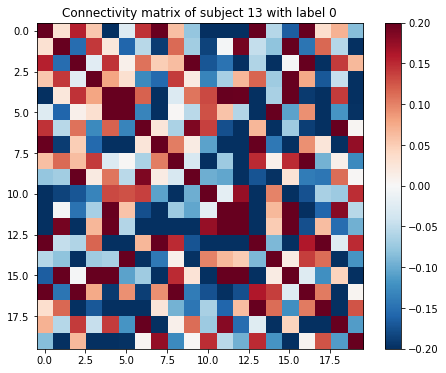

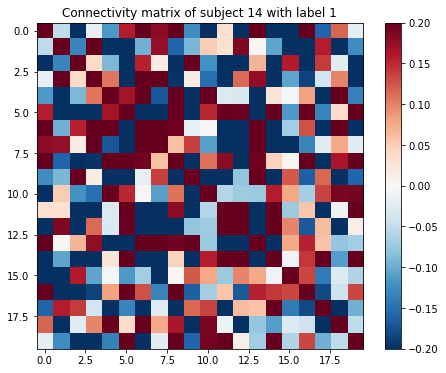

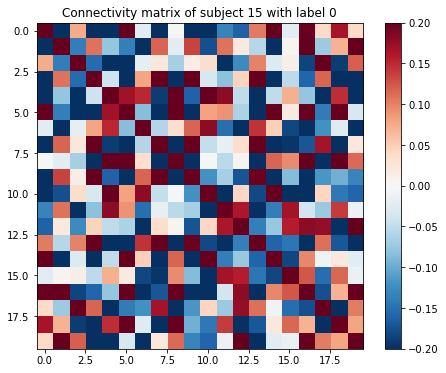

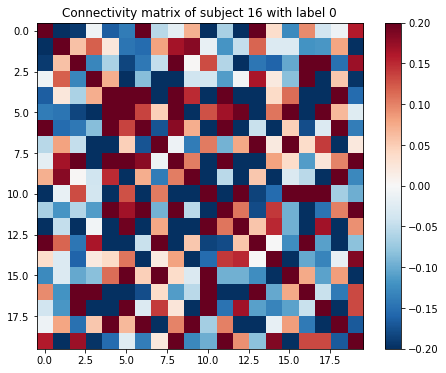

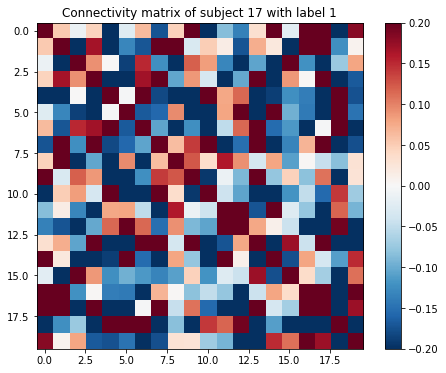

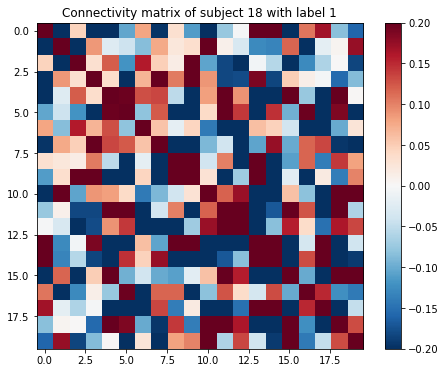

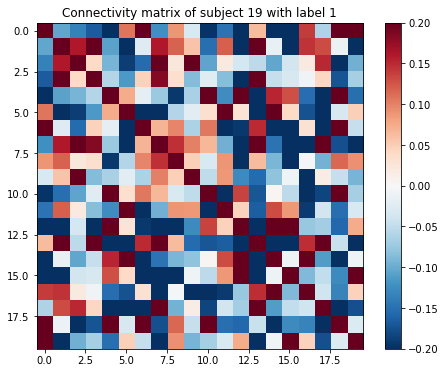

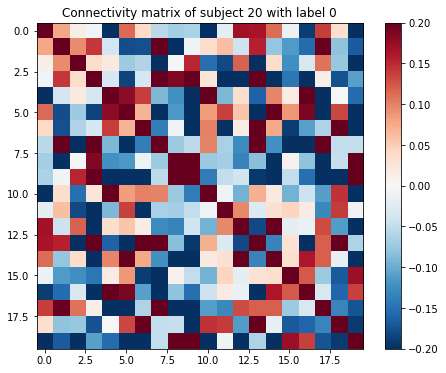

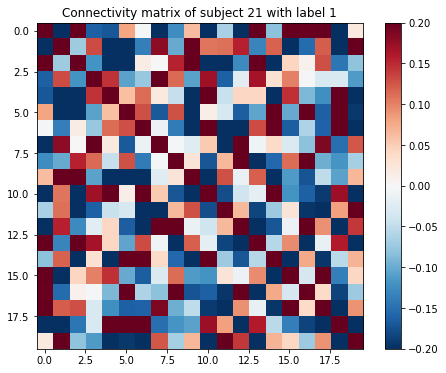

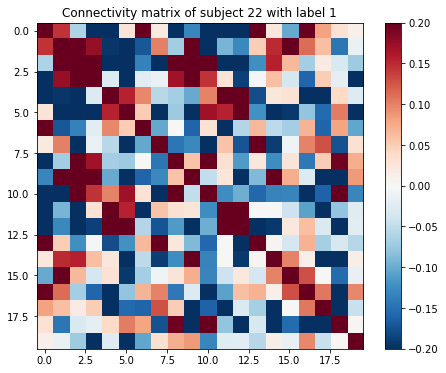

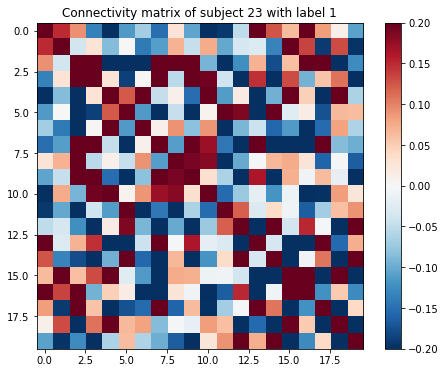

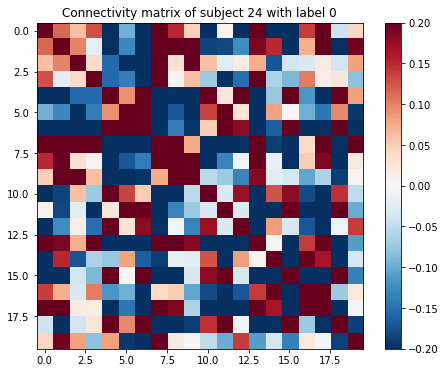

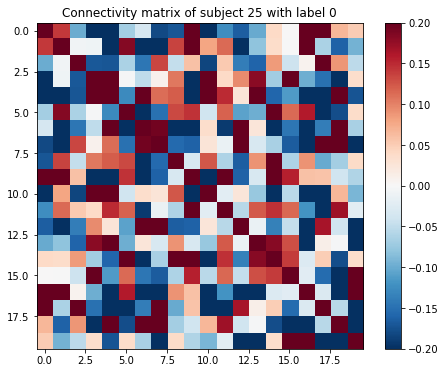

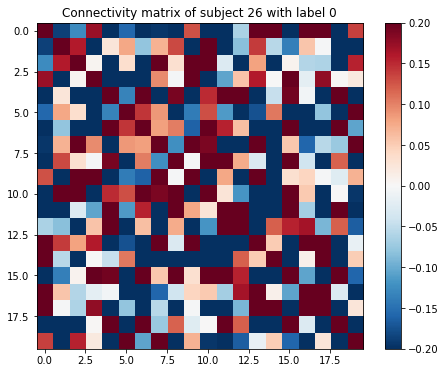

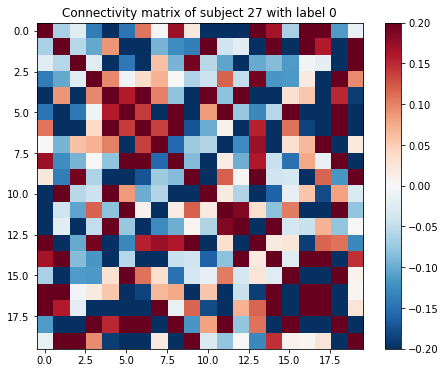

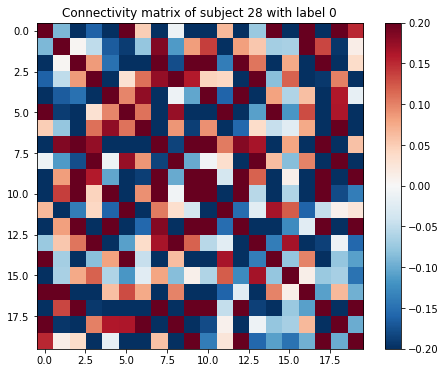

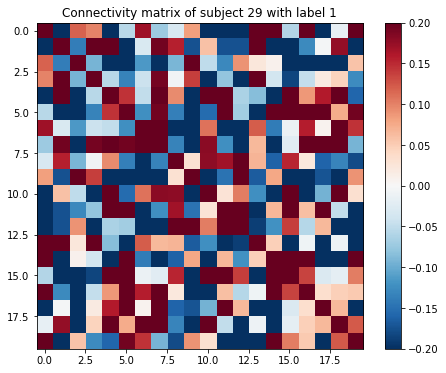

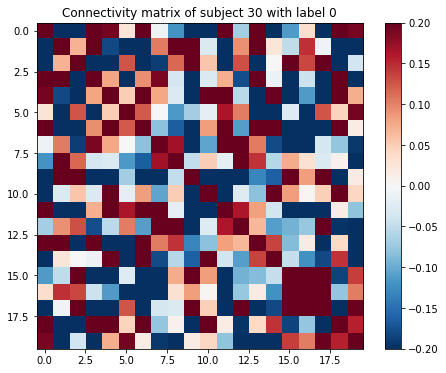

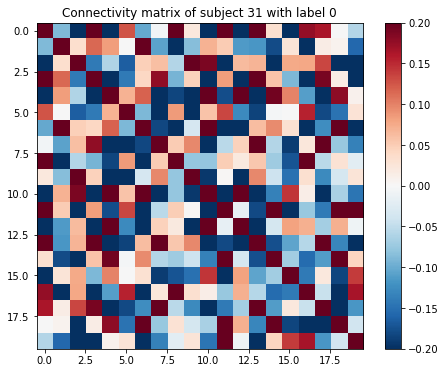

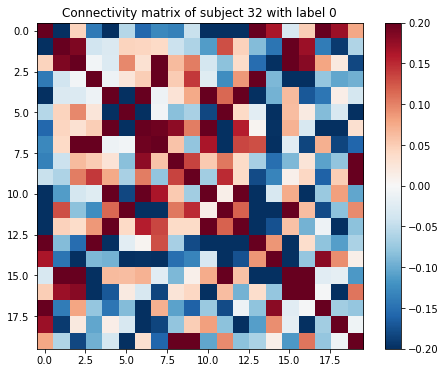

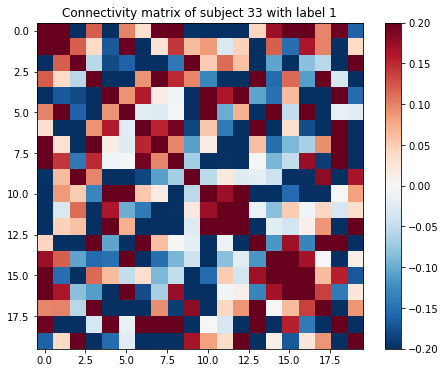

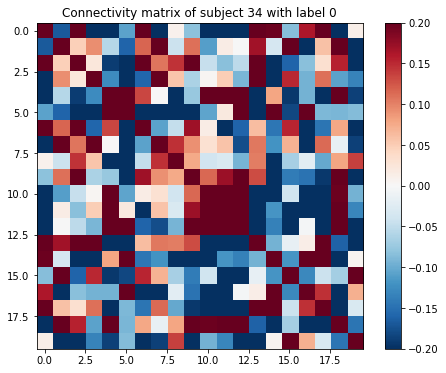

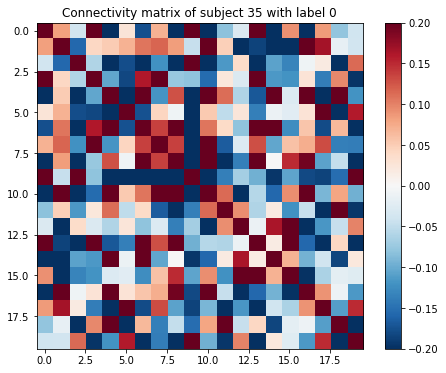

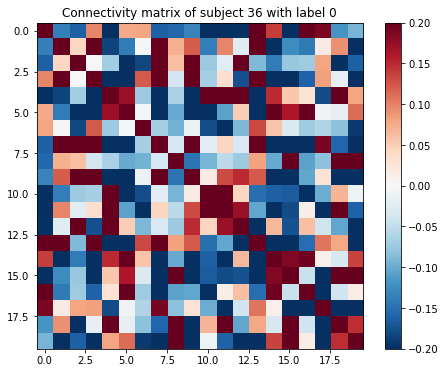

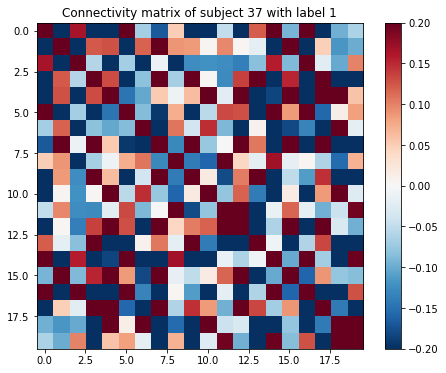

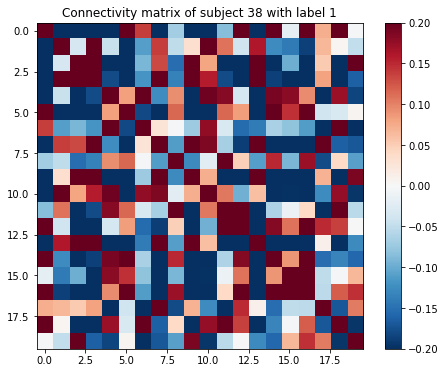

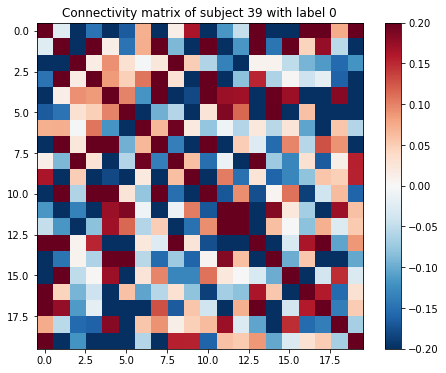

In [41]:
#Displaying the connectomes for the most accurate kind of functional connectivity
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(subjects)


for i in range(40):
    plt.figure(figsize=(8,6))
    plt.imshow(correlation_matrices[i], vmax=.20, vmin=-.20, cmap='RdBu_r')
    plt.colorbar()
    plt.title('Connectivity matrix of subject {} with label {}'.format(i, labels[i]))

In [42]:
#Separating the correlation matrices between treatment and control subjects
adhd_correlations = []
control_correlations = []
for i in range(40):
    if labels[i] == 1:
        adhd_correlations.append(correlation_matrices[i])
    else:
        control_correlations.append(correlation_matrices[i])

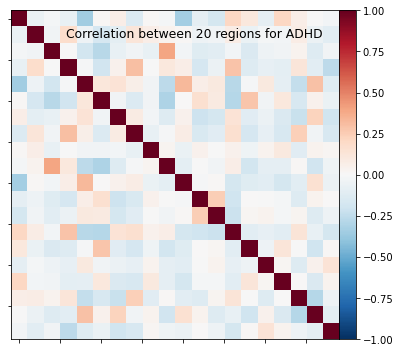

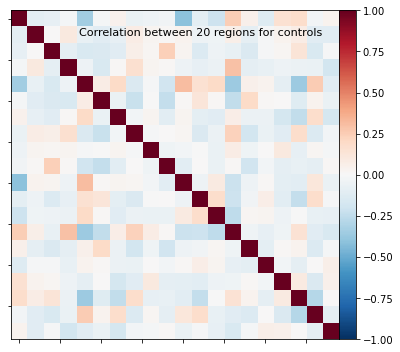

In [43]:
#Getting the mean correlation matrix across all treatment subjects
mean_correlations_adhd = np.mean(adhd_correlations, axis=0).reshape(time_series.shape[-1],
                                                          time_series.shape[-1])

#Getting the mean correlation matrix across all control subjects
mean_correlations_control = np.mean(control_correlations, axis=0).reshape(time_series.shape[-1],
                                                          time_series.shape[-1])

#Visualizing the mean correlation
plotting.plot_matrix(mean_correlations_adhd, vmax=1, vmin=-1,
                               colorbar=True, title='Correlation between 20 regions for ADHD')

plotting.plot_matrix(mean_correlations_control, vmax=1, vmin=-1,
                               colorbar=True, title='Correlation between 20 regions for controls')

#Getting the center coordinates from the component decomposition to use as atlas labels
coords = plotting.find_probabilistic_atlas_cut_coords(components_img)

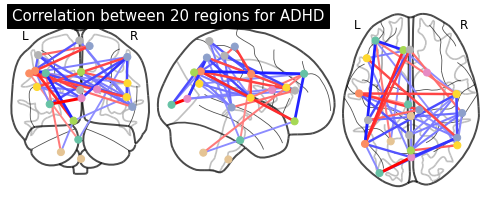

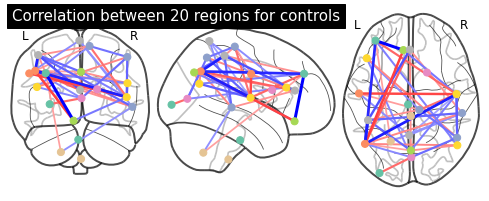

In [44]:
#Plotting the connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlations_adhd, coords,
                         edge_threshold="80%", title='Correlation between 20 regions for ADHD')

plotting.plot_connectome(mean_correlations_control, coords,
                         edge_threshold="80%", title='Correlation between 20 regions for controls')
plotting.show()

In [45]:
#Creating the equivalent interactive visualization
view = plotting.view_connectome(mean_correlations_adhd, coords, edge_threshold='80%')
view

In [46]:
view = plotting.view_connectome(mean_correlations_control, coords, edge_threshold='80%')
view

The Neural Networks Way
We use the correlation matrices of the functional connectivity as input data for our neural network. We build a Sequential model made up of four Dense layers.

In [47]:
#Splitting data into training and testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(connectivity_biomarkers['correlation'], labels, test_size=0.3)

In [48]:
#Creating the classification model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=connectivity_biomarkers['correlation'].shape[1:]))
#Second  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Third  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [49]:
#Compiling the model
classifier.compile(optimizer = Adam(lr =.0001),loss='binary_crossentropy', metrics =['accuracy'])

In [50]:
#Fitting the model
classifier.fit(np.array(X_train),np.array(y_train), batch_size=32, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 454ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5357
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5714
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5714
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.6429
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.7143
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.6786
Epoch 10/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.6071
Epoch 11/100
1/1 [=========

In [51]:
#Determining accuracy on training
eval_model=classifier.evaluate(np.array(X_train), np.array(y_train))
eval_model

1/1 [==============================] - 0s 111ms/step - loss: 0.6896 - accuracy: 0.6071


[0.6895716786384583, 0.6071428656578064]

In [52]:
#Making the classification and determining accuracy
y_pred=classifier.predict(X_test,batch_size=32)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

1/1 [==============================] - 0s 113ms/step
[[5 0]
 [7 0]]
              precision    recall  f1-score   support

           0       0.42      1.00      0.59         5
           1       0.00      0.00      0.00         7

    accuracy                           0.42        12
   macro avg       0.21      0.50      0.29        12
weighted avg       0.17      0.42      0.25        12

